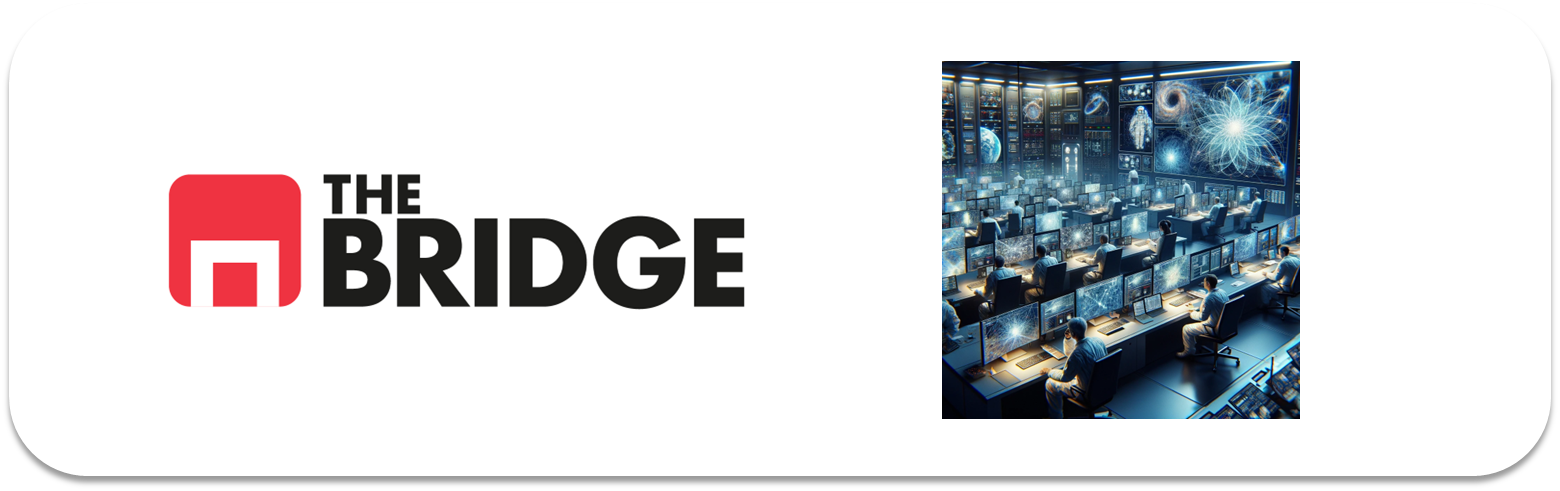

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import keras
import cv2

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".

In [2]:
root_path = "./data/"
path_0 = root_path+"github_train_0"
path_1 = root_path+"github_train_1"
path_2 = root_path+"github_train_2"
path_3 = root_path+"github_train_3"
test_path = root_path+"github_test"

In [3]:
def read_data(directorio, reshape_dim=(32,32)):
    X=[]
    y=[]
    for file in os.listdir(directorio):
        image = imread("/".join([directorio, file]))
        image = cv2.resize(image, reshape_dim)

        X.append(image)
        y.append(0 if 'dog' in file else 1)
    return np.array(X), np.array(y)

In [4]:
X_test, y_test = read_data(test_path)

In [5]:
X_test.shape, y_test.shape

((1000, 32, 32, 3), (1000,))

In [6]:
root_path = "./data/"
paths = [root_path+"github_train_0", root_path+"github_train_1", root_path+"github_train_2", root_path+"github_train_3"]

X_train_list = []
y_train_list = []

for path in paths:
    X_part, y_part = read_data(path)
    X_train_list.append(X_part)
    y_train_list.append(y_part)

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)


In [7]:
X_train.shape, y_train.shape

((4000, 32, 32, 3), (4000,))

In [8]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([2000, 2000], dtype=int64))

balanceadito

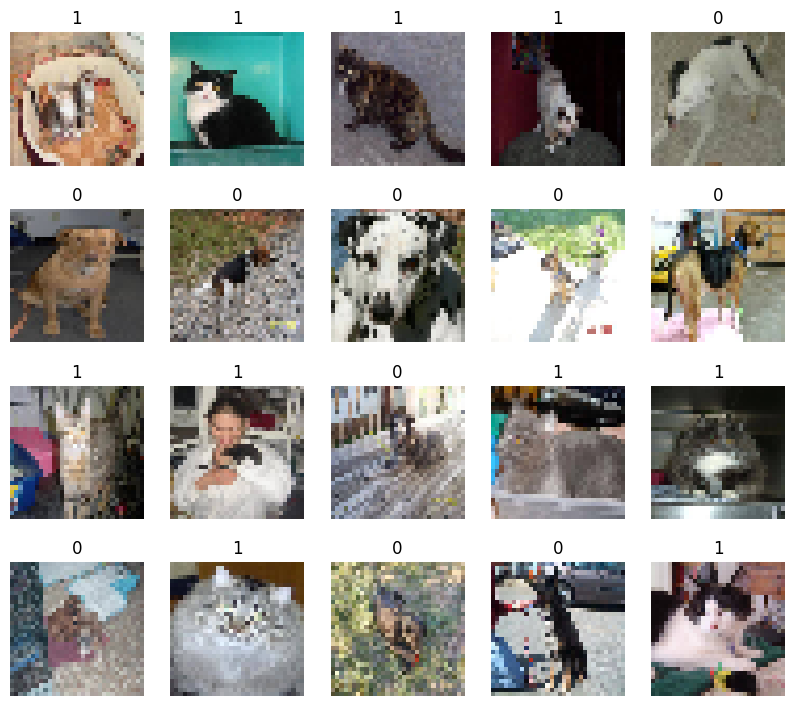

In [9]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])
            
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [10]:
mapa = {0:"perro",
        1:"gato"}

In [11]:
X_train = X_train/255
X_test = X_test/255

In [12]:
X_train[0].shape

(32, 32, 3)

In [13]:
capas = [keras.layers.Input(shape=X_train[0].shape),
         keras.layers.Conv2D(filters = 30, kernel_size = (3, 3),
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

         keras.layers.Conv2D(filters = 15, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

         keras.layers.Flatten(),

         keras.layers.Dense(units = 150, activation = 'relu'),
        #  keras.layers.Dense(units=150,activation="relu"),

         keras.layers.Dense(1, activation = 'sigmoid')]

model = keras.Sequential(capas)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 30)     │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │       144,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,206 (582.84 KB)

 Trainable params: 149,206 (582.84 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
X_train, y_train = shuffle(X_train, y_train)

In [15]:
y_train.shape

(4000,)

In [16]:
history = model.fit(X_train,
                    y_train,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 32, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)]) # Queremos recuperar los pesos de la mejor de las epocas durante el periodo de patience

Epoch 1/100


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5119 - loss: 0.6998 - val_accuracy: 0.6087 - val_loss: 0.6654
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6220 - loss: 0.6457 - val_accuracy: 0.6712 - val_loss: 0.6104
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7076 - loss: 0.5804 - val_accuracy: 0.7088 - val_loss: 0.5705
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7043 - loss: 0.5647 - val_accuracy: 0.7138 - val_loss: 0.5673
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7450 - loss: 0.5157 - val_accuracy: 0.6938 - val_loss: 0.5762
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7589 - loss: 0.4965 - val_accuracy: 0.7200 - val_loss: 0.5506
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7657 - loss: 0.4760 - val_accuracy: 0.7325 - val_loss: 0.5526
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7869 - loss: 0.4466 - val_accuracy

In [17]:
pd.DataFrame(history.history).tail()

,accuracy,loss,val_accuracy,val_loss
11,0.874062,0.304339,0.70375,0.661631
12,0.884375,0.273891,0.71000,0.712080
13,0.909375,0.227378,0.69875,0.716379
14,0.925625,0.189536,0.69875,0.779646
15,0.940000,0.163889,0.69500,0.888514


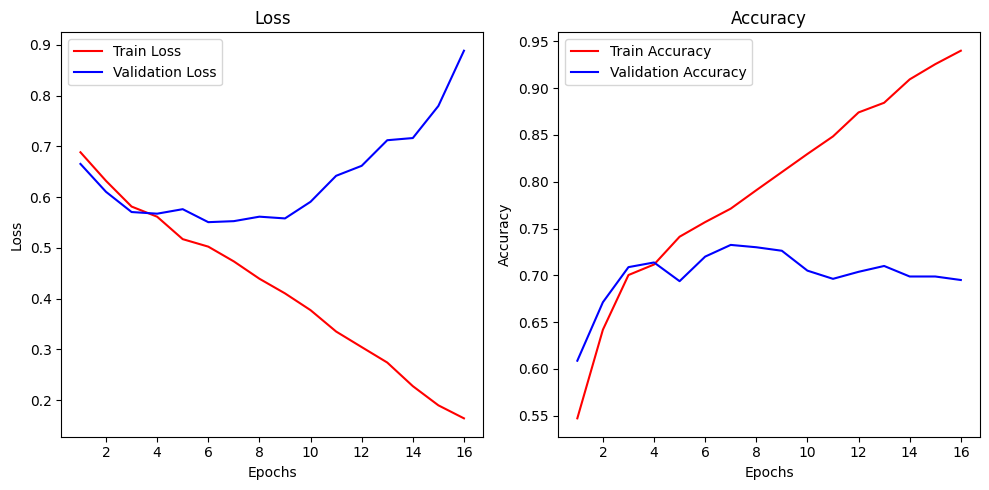

In [18]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Graficar la métrica seleccionada (precisión)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6825 - loss: 0.5874


[0.5743937492370605, 0.7020000219345093]

In [20]:
predictions = model.predict(X_test)
y_pred = (predictions > 0.5).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


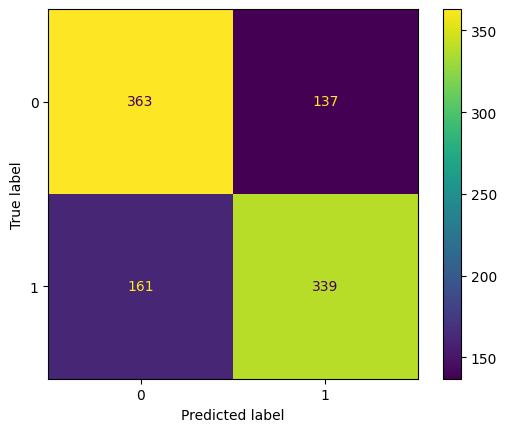

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       500
           1       0.71      0.68      0.69       500

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



In [23]:
y_pred.shape

(1000, 1)

In [24]:
y_test_labels = pd.Series(y_test).map(mapa)
y_pred_labels = pd.Series(y_pred.reshape(1000,)).map(mapa)
confianza = predictions.reshape(1000,)

pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confianza": confianza})

error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores

,True,Predicted,Confianza
680,perro,gato,0.968690
537,perro,gato,0.947225
662,perro,gato,0.946729
923,perro,gato,0.942150
851,perro,gato,0.940447
...,...,...,...
107,gato,perro,0.095744
368,gato,perro,0.083985
153,gato,perro,0.061446
337,gato,perro,0.022939


In [25]:
errores_perro = errores[errores['True'] == "perro"]
errores_perro

,True,Predicted,Confianza
680,perro,gato,0.968690
537,perro,gato,0.947225
662,perro,gato,0.946729
923,perro,gato,0.942150
851,perro,gato,0.940447
...,...,...,...
825,perro,gato,0.515986
617,perro,gato,0.512107
765,perro,gato,0.508393
625,perro,gato,0.507943


In [26]:
diez_porciento = int(len(errores_perro)/10)

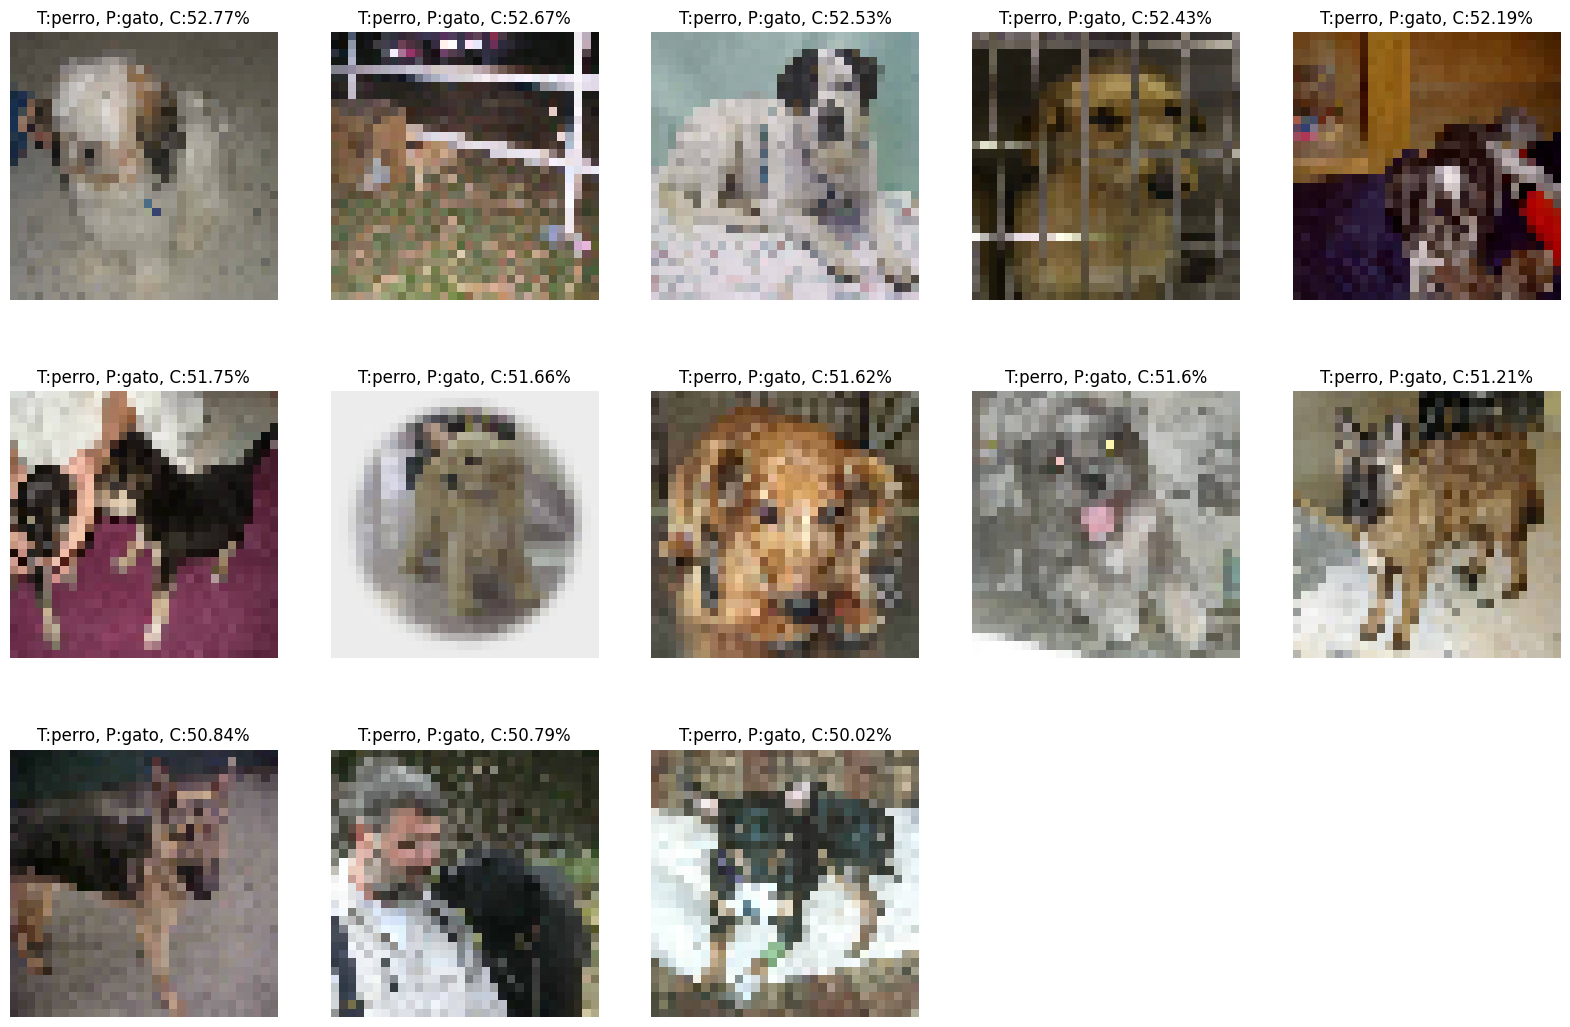

In [27]:
# mostrar los pred gato con menos probabilidad de ser gatos

show_images_batch(X_test[errores_perro.iloc[-diez_porciento:].index],names= [f"T:{val1}, P:{val2}, C:{round(val3*100,2)}%" for val1,val2,val3 in errores_perro.iloc[-diez_porciento:].values], size_scale= 4)

In [28]:
errores_gato = errores[errores["True"]=="gato"]
errores_gato

,True,Predicted,Confianza
226,gato,perro,0.495052
33,gato,perro,0.494125
137,gato,perro,0.493098
431,gato,perro,0.491535
310,gato,perro,0.490737
...,...,...,...
107,gato,perro,0.095744
368,gato,perro,0.083985
153,gato,perro,0.061446
337,gato,perro,0.022939


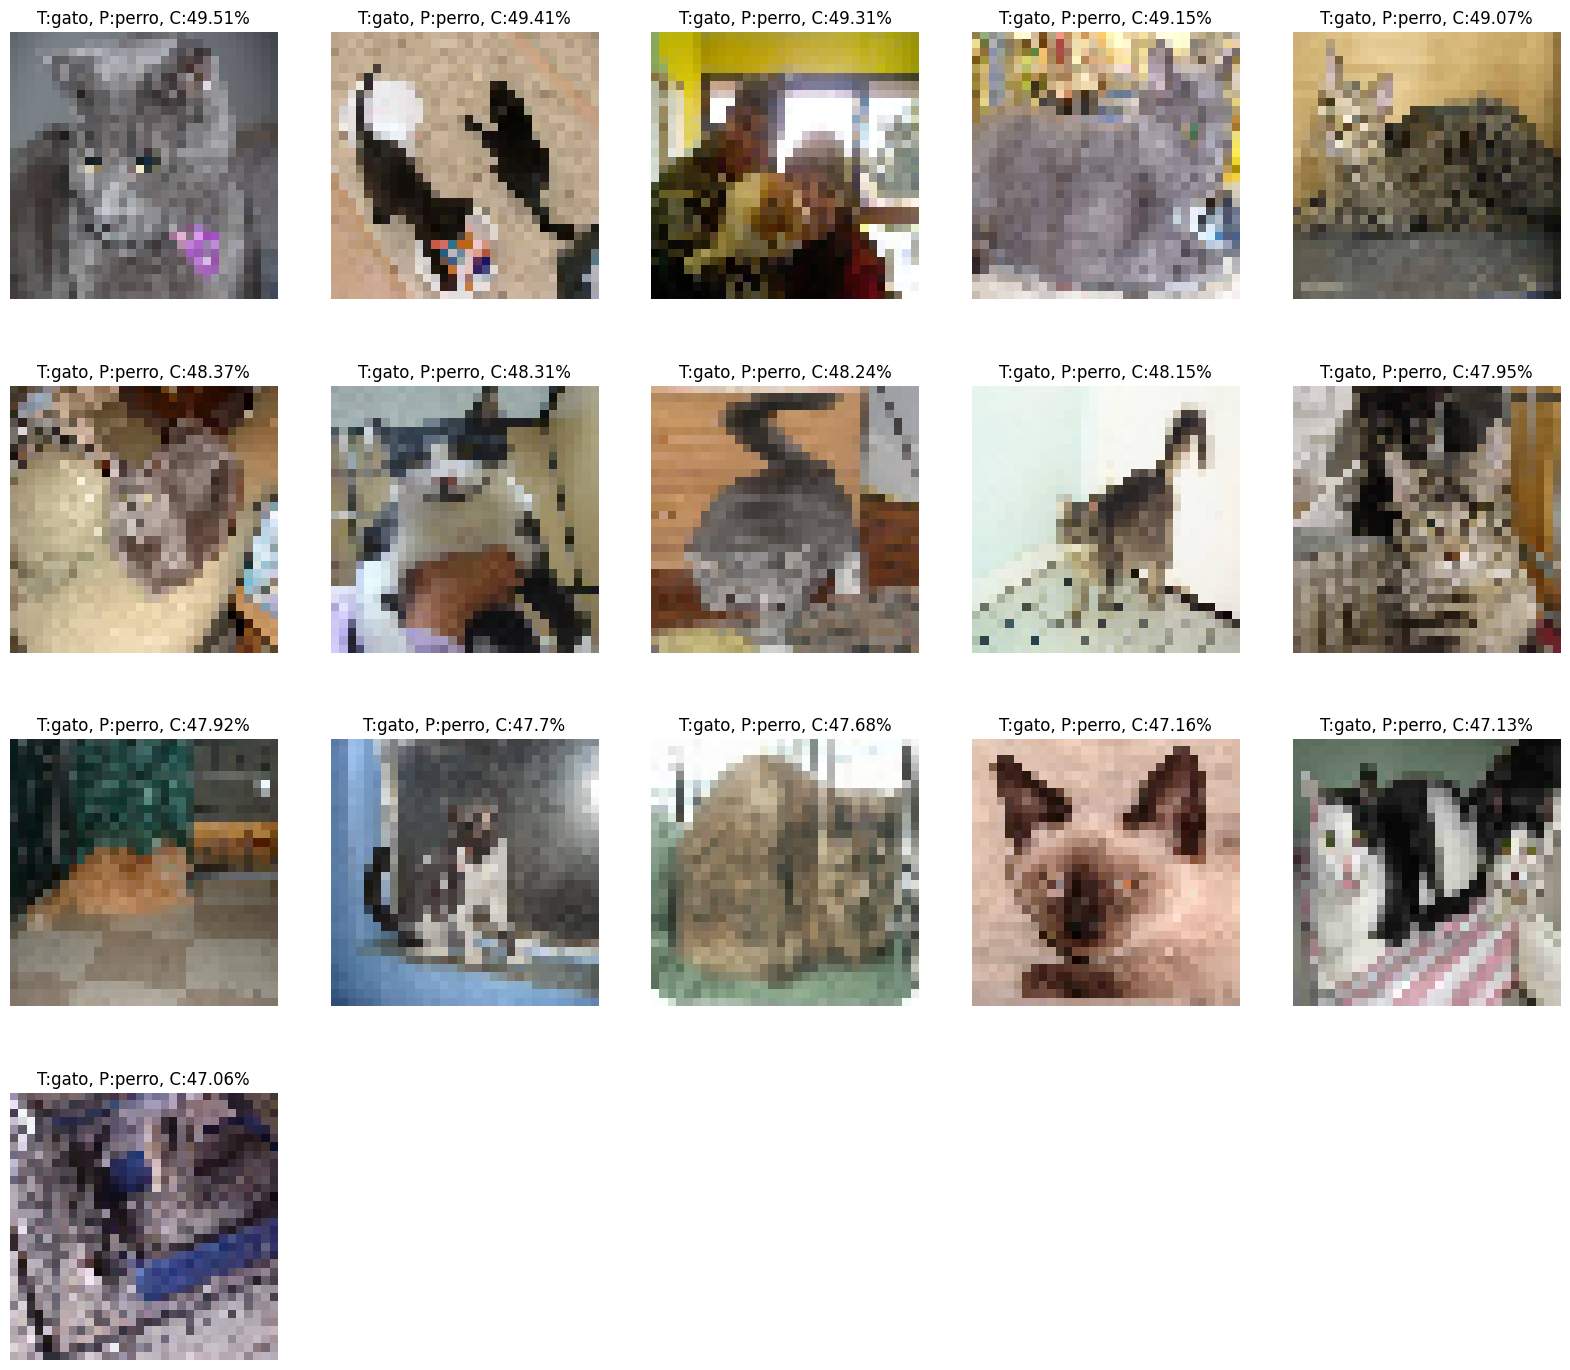

In [29]:
diez_porciento = int(len(errores_gato)/10)

# mostrar los pred perro con menos probabilidad de ser perro

show_images_batch(X_test[errores_gato.iloc[0:diez_porciento:].index],names= [f"T:{val1}, P:{val2}, C:{round(val3*100,2)}%" for val1,val2,val3 in errores_gato.iloc[0:diez_porciento:].values], size_scale= 4)

### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



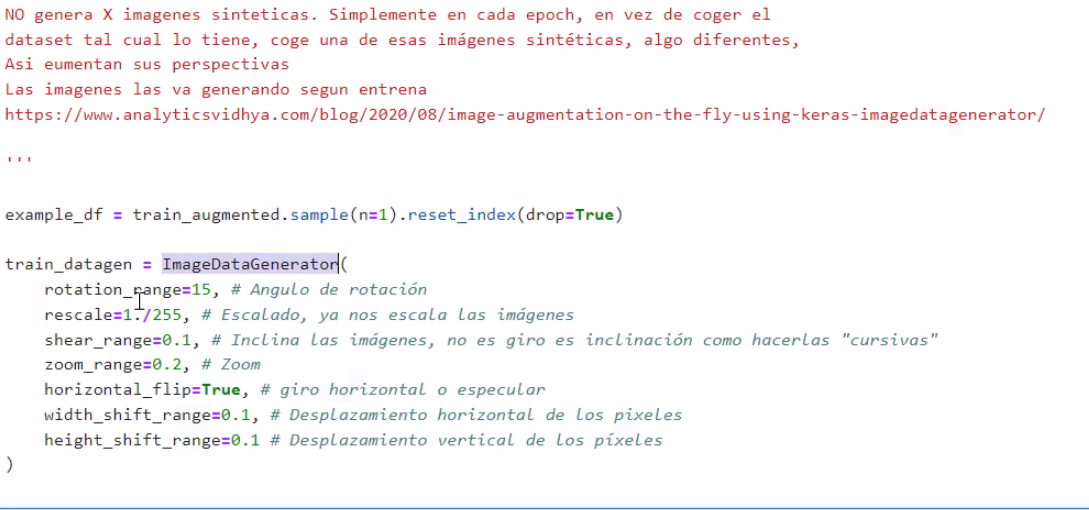

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.